# Cuaderno 3: análisis prospectivo

En este cuaderno haremos simulaciones prospectivas y replicaremos algunas figuras del reporte.

## Importamos librerías de Python

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Importamos IPP

In [2]:
import requests
url = 'https://raw.githubusercontent.com/oguerrer/IPP_Lima/main/code/ppi.py'
r = requests.get(url)
with open('ppi.py', 'w') as f:
    f.write(r.text)
import ppi

## Cargamos la base de los indicadores y la red

In [11]:
# cargamos base de datos
datos = pd.read_csv('https://raw.githubusercontent.com/oguerrer/IPP_Lima/main/data/base_final.csv')

# obetnemos vector indicando qué indicadores son instrumentales
R = datos.Instrumental.values

# obetenemos los parámetros de gobernanza
cc = datos['control_corrupcion'].values[0]
rl = datos['estado_de_derecho'].values[0]

# cargamos la red de interdependencias
A = np.loadtxt('https://raw.githubusercontent.com/oguerrer/IPP_Lima/main/data/red/A.csv', dtype=float, delimiter=',')

# obtenemos los valores máximos teóricos reportados en la base de indicadores
max_theo = datos['Máx teórico'].values*scalar

## Cargamos los parámetros calibrados para el reporte

In [8]:
# cargamos base de datos
parametros = pd.read_csv('https://raw.githubusercontent.com/oguerrer/IPP_Lima/main/data/parametros.csv')

alphas = parametros.alphas.values.copy() # vector de parametros alfa
betas = parametros.beta.values.copy() # vector de parametros beta
max_steps = int(parametros.steps.values[0]) # número de periodos simulados en la calibración
num_years = parametros.years.values[0] # número de años en el periodo muestral (en la calibración)
sub_periodos = int(max_steps/num_years) # sub-periodos de pago en el calendario de desembolsos
scalar = parametros.scalar.values[0] # el escalar usado durante la calibración

## Establecemos las condiciones iniciales (usamos los valores de 2020)

In [10]:
I0 = datos['2020'].values.copy()*scalar

## Proyectamos los datos presupuestarios usando la tasa anual de crecimiento empírica

In [25]:
# cargamos datos
dfb = pd.read_csv('https://raw.githubusercontent.com/oguerrer/IPP_Lima/main/data/base_presupuesto.csv')
dfb = dfb.groupby('ODS').sum()

# determinamos el número de años que simularemos hacia adelante
anios_proyectados = 10

# establecemos la tasa de crecimiento anual
interest = 0.095

# armamos el calendario de desembolso
bench = dfb['2020'].values/(sub_periodos)
B_sequence = np.zeros((len(dfb), int(anios_proyectados*sub_periodos)))
for i in range(B_sequence.shape[1]):
    B_sequence[:,i] = bench
    if i%int(sub_periodos)==0:
        bench *= (1+interest)
        
# armamos la vinculación entre indicadores y ODS
budget_hash = dict([ (i, ods[(ods!='nan') & (ods != '10.0')].astype(float).astype(int).tolist()) for i, ods in enumerate(datos[['ODS1', 'ODS2']].values.astype(str)) ])

## Corremos una simulación

Para correr una simulación hay que ejecutar el comando `run_ppi` de la librería de IPP. El comando toma como insumo los parámetros y datos preparados previamente y detiene la simulación una vez que se ha cubierto el calendario de desembolsos. Al terminar, `run_ppi` regresa los siguientes datos (en el orden especificado):

* Una matriz con las series de tiempo simuladas de cada indicador (fila=indicador; columna=periodo)
* Una matriz con las series de tiempo de las contribuciones de cada agente (fila=indicador; columna=periodo; solo cubre indicadores instrumentales)
* Una matriz con las series de tiempo de los beneficios de cada agente (fila=indicador; columna=periodo; solo cubre indicadores instrumentales)
* Una matriz con las series de tiempo de las asignaciones presupuestales a cada indicador (fila=indicador; columna=periodo; solo cubre indicadores instrumentales)
* Una matriz con las series de tiempo de los dispendios en cada indicador (fila=indicador; columna=periodo; solo cubre indicadores instrumentales)
* Una matriz con las series de tiempo de las derramas netas entrantes a cada indicador (fila=indicador; columna=periodo)
* Una lista con el periodo en el que cada indicador llega a su meta (esta función ha sido depreciada y será eliminada en la siguiente versión de IPP; solo devuelve una lista con valores nulos)
* Una lista con el historial promedio de dispendios detectados por el agente gobierno
* Una matriz con las probabilidades de éxito de cada indicador a través del tiempo (solo si se usa el aegumento `get_gammas=True`, de lo contrario se obtiene una lista vacía; esto lo usa el algoritmo de calibración)

In [38]:
# corremos la simulación y guardamos sus resultados
resultados = ppi.run_ppi(I0, A=A, R=R, alpha=alphas, cc=cc, rl=rl, max_theo=max_theo,
            betas=betas, scalar=scalar, B_sequence=B_sequence, budget_hash=budget_hash)

# guardamos los resultados en variables separadas
tsI, tsC, tsF, tsP, tsD, tsS, ticks, H, all_gammas = resultados

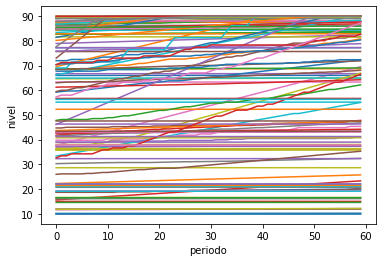

In [44]:
# graficamos la evolución de cada indicador
for serie in tsI:
    plt.plot(serie)
plt.xlabel('periodo')
plt.ylabel('nivel')
plt.show()

## Obtenemos estadísticas de múltiples simulaciones

Corremos una muestra de simulaciones independientes y promediamos la dinámica de los indicadores. En particular, nos interesa calcular el valor final promedio de cada indicador y la brecha que quedaría abierta en 2030 con respecto a la meta.

In [47]:
# corremos 100 simulaciones y guardamos los valores finales
valores_finales = []
for sim in range(100):
    resultados = ppi.run_ppi(I0, A=A, R=R, alpha=alphas, cc=cc, rl=rl, max_theo=max_theo,
                betas=betas, scalar=scalar, B_sequence=B_sequence, budget_hash=budget_hash)
    tsI, tsC, tsF, tsP, tsD, tsS, ticks, H, all_gammas = resultados
    valores_finales.append(tsI[:,-1])

In [56]:
# promediamos los valores finales para cada indicador a través de las simulaciones
valores_finales_promedio = np.mean(valores_finales, axis=0)

# obtenemos las metas de la base de indicadores
metas = datos['Meta'].values.copy()*scalar

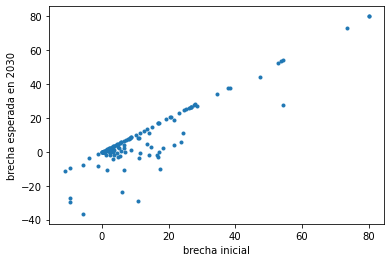

In [60]:
# calculamos brechas entre la meta y el indicador en 2020 (la brecha inicial)
brechas_hist = metas - I0

# calculamos brechas esperadas en 2030
brechas_esp = metas - valores_finales_promedio

# comparamos bregas históricas contra esperadas
plt.plot(brechas_hist, brechas_esp, '.')
plt.xlabel('brecha inicial')
plt.ylabel('brecha esperada en 2030')
plt.show()

## Un gráfico más sofisticado sobre el cierre de brechas

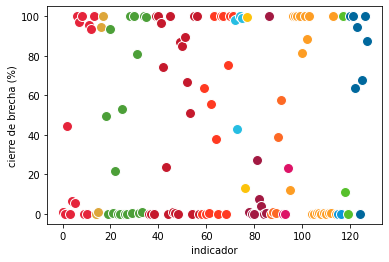

In [105]:
# calculamos el cierre de brechas (¿qué porcentaje de la brecha inicial se espera cerrar en 2030?)
cierre = 100*(1-brechas_esp/brechas_hist)
cierre[brechas_hist<=0] = 100
cierre[brechas_esp<=0] = 100

# cargamos los colores de los ODS
colores = pd.read_csv('https://raw.githubusercontent.com/oguerrer/IPP_Lima/main/data/color_codes.txt', header=None)
colores_ods = dict(zip(colores.index+1, colores.values.flatten()))

# graficamos cada indicador con su brecha y el color de su ODS
for index, row in datos.iterrows():
    plt.plot(index, cierre[index], '.', mec='w', mfc=colores_ods[row['ODS1']], markersize=20)
plt.xlabel('indicador')
plt.ylabel('cierre de brecha (%)')
plt.show()

## Un histograma com las brechas promedio por ODS

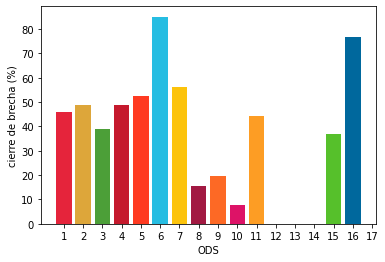

In [114]:
los_ods = datos['ODS1'].unique()
for ods in los_ods:
    cierre_promedio = np.mean(cierre[datos['ODS1'].values==ods])
    plt.bar(ods, cierre_promedio, color=colores_ods[ods])
plt.xticks(range(1,18))
plt.xlabel('ODS')
plt.ylabel('cierre de brecha (%)')
plt.show()

## Contrafactual con un crecimiento presupuestal al triple de velocidad

An este ejercicio creamos un calendario de desembolsos que crece a una tasa anual del 30%, en lugar del 9.5% histórico. Se corren las simulaciones con este presupuesto contrafactual y se estiman los cierres de brecha.

In [115]:
# establecemos la tasa de crecimiento anual
interest = 0.3

# armamos el calendario de desembolso
bench_contra = dfb['2020'].values/(sub_periodos)
B_sequence_contra = np.zeros((len(dfb), int(anios_proyectados*sub_periodos)))
for i in range(B_sequence_contra.shape[1]):
    B_sequence_contra[:,i] = bench
    if i%int(sub_periodos)==0:
        bench_contra *= (1+interest)
        
# armamos la vinculación entre indicadores y ODS
budget_hash_contra = dict([ (i, ods[(ods!='nan') & (ods != '10.0')].astype(float).astype(int).tolist()) for i, ods in enumerate(datos[['ODS1', 'ODS2']].values.astype(str)) ])

In [120]:
# corremos IPP usando presupuesto contrafactual
valores_finales_contra = []
for sim in range(100):
    resultados = ppi.run_ppi(I0, A=A, R=R, alpha=alphas, cc=cc, rl=rl, max_theo=max_theo,
                betas=betas, scalar=scalar, B_sequence=B_sequence_contra, budget_hash=budget_hash_contra)
    tsI, tsC, tsF, tsP, tsD, tsS, ticks, H, all_gammas = resultados
    valores_finales_contra.append(tsI[:,-1])
    
# promediamos los valores finales para cada indicador a través de las simulaciones
valores_finales_promedio_contra = np.mean(valores_finales_contra, axis=0)

# calculamos brechas esperadas en 2030
brechas_esp_contra = metas - valores_finales_promedio_contra

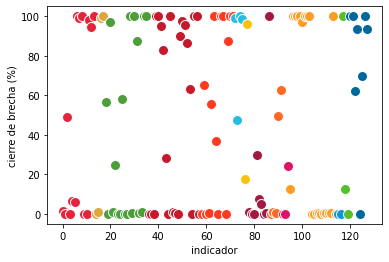

In [121]:
# calculamos el cierre de brechas (¿qué porcentaje de la brecha inicial se espera cerrar en 2030?)
cierre_contra = 100*(1-brechas_esp_contra/brechas_hist)
cierre_contra[brechas_hist<=0] = 100
cierre_contra[brechas_esp_contra<=0] = 100

# graficamos cada indicador con su brecha y el color de su ODS
for index, row in datos.iterrows():
    plt.plot(index, cierre_contra[index], '.', mec='w', mfc=colores_ods[row['ODS1']], markersize=20)
plt.xlabel('indicador')
plt.ylabel('cierre de brecha (%)')
plt.show()

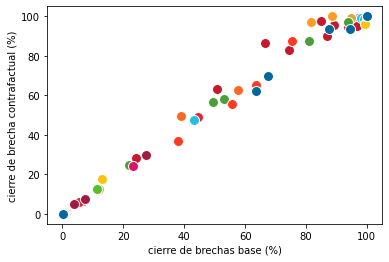

In [130]:
# comparamos los cierres de brecha entre las simulaciones base y las contrafactuales
for index, row in datos.iterrows():
    plt.plot(cierre[index], cierre_contra[index], '.', mec='w', mfc=colores_ods[row['ODS1']], markersize=20)
plt.xlabel('cierre de brechas base (%)')
plt.ylabel('cierre de brecha contrafactual (%)')
plt.show()

## Análisis de fronteras presupuestales

Ahora vamos a correr simulaciones prospectivas donde se asume un presupuesto ilimitado y efficiencia plena en el uso de los recursos. Este escenario hipotético se denomina *frontera presupuestaria* y es útil para identificar temas de política que, aún sin restricciones presupuestales, tienen programas de gobierno que no inciden en el avance de los indicadores.

Para implementar el análisis de frontera, no es necesario armar un calendario de desembolsos contrafactual, sino activar el parámetro `force_gammas=True` en la función `run_ppi`.

In [131]:
# corremos IPP bajo la frontera presupuestal
valores_finales_front = []
for sim in range(100):
    resultados = ppi.run_ppi(I0, A=A, R=R, alpha=alphas, cc=cc, rl=rl, max_theo=max_theo,
                betas=betas, scalar=scalar, B_sequence=B_sequence, budget_hash=budget_hash, force_gammas=True)
    tsI, tsC, tsF, tsP, tsD, tsS, ticks, H, all_gammas = resultados
    valores_finales_front.append(tsI[:,-1])
    
# promediamos los valores finales para cada indicador a través de las simulaciones
valores_finales_promedio_front = np.mean(valores_finales_front, axis=0)

# calculamos brechas esperadas en 2030
brechas_esp_front = metas - valores_finales_promedio_front

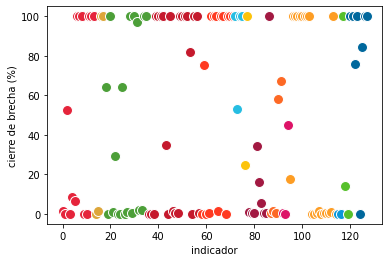

In [132]:
# calculamos el cierre de brechas (¿qué porcentaje de la brecha inicial se espera cerrar en 2030?)
cierre_front = 100*(1-brechas_esp_front/brechas_hist)
cierre_front[brechas_hist<=0] = 100
cierre_front[brechas_esp_front<=0] = 100

# graficamos cada indicador con su brecha y el color de su ODS
for index, row in datos.iterrows():
    plt.plot(index, cierre_front[index], '.', mec='w', mfc=colores_ods[row['ODS1']], markersize=20)
plt.xlabel('indicador')
plt.ylabel('cierre de brecha (%)')
plt.show()

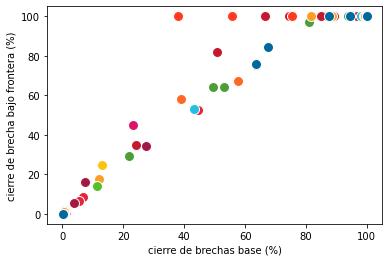

In [133]:
# comparamos los cierres de brecha entre las simulaciones base y las de frontera
for index, row in datos.iterrows():
    plt.plot(cierre[index], cierre_front[index], '.', mec='w', mfc=colores_ods[row['ODS1']], markersize=20)
plt.xlabel('cierre de brechas base (%)')
plt.ylabel('cierre de brecha bajo frontera (%)')
plt.show()